In [4]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.98
set_session(tf.Session())
from sample_models import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Automatic Speech Recognition on the DASS Corpus


# Motivation

* DASS (Digital Archive of Southern Speech)

From the website -- The Digital Archive of the Southern Speech (DASS) is an audio corpus of semi-spontaneous linguistic atlas interviews (Kretzschmar et al. 2013) derived from the Linguistic Atlas of the Gulf States (Pederson et al. 1986). It contains speech from 64 natives (34 men and 30 women, born 1886–1965) of 8 Southern US states. This sample contains a mixture of ethnicities, social classes, education levels, and ages.  http://lap3.libs.uga.edu/u/jstanley/vowelcharts/

* What kind of data do we have?

Transcription, forced alignment, and acoustic analysis.

* What do we care about?

**ACCURACY!** 

In particular, World Error Rate (WER).

A funny quote here:

**"Every time I fire a linguist, the performance of the speech recognizer goes up".** -- Frederick Jelinek, *the* pioneer of speech recognition

Is that the case? I can elaborate..... as we will see soon. 


# Background
* Landscape of speech recognition
    * HMM, GMM, etc. 
    * State of the art, Deep Neural Network (some with HMM as well)
* End-to-end model
    * Baidu's DeepSpeech
    
* Training Dataset
    * LibriSpeech
    * Publicly available (http://www.openslr.org/12/)
    * Commonly used for benchmarks


# Approaches 
* Preprocessing (spectrogram, MFCC)
    * Some other people also use raw audio or the combinations with spectrogram and MFCC.
    * Encode - decode
* Training (CNN, Bi-directional Deep RNN, TDNN+LSTM etc.) acoustic model
* Acoustic model output → language model → results
    * LM -- some part of PaddlePaddle from Baidu
* Where we borrow stuff
    * Udacity, Baidu, WER model. 

## Preprocessing

* Raw Audio: 
    * Use `python_speech_features` and `soundfile` to extract features for deep learning. 

In [1]:
from data_generator import *
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()


There are 2023 total training examples.


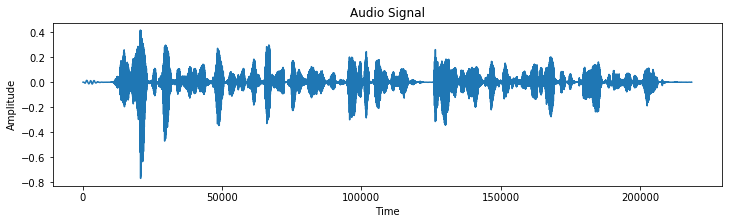

**Shape of Audio Signal** : (218626,)

**Transcript** : shortly after passing one of these chapels we came suddenly upon a village which started up out of the mist and i was alarmed lest i should be made an object of curiosity or dislike

In [2]:
from IPython.display import Markdown, display
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

## Feature Extraction
* Spectrogram

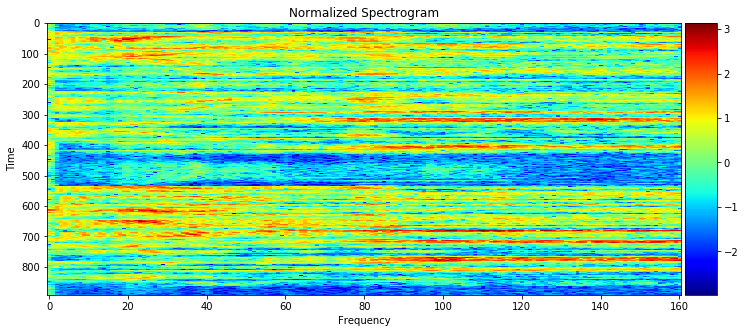

**Shape of Spectrogram** : (892, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

* MFCC

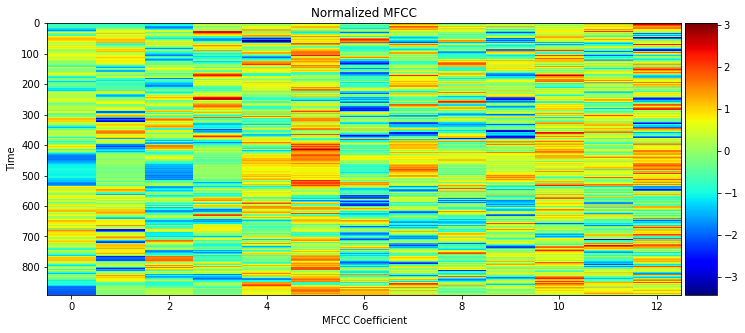

**Shape of MFCC** : (892, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

# Training

## CNN + RNN + TimeDistributed Dense

<img src="images/cnn_rnn_model.png" width="70%">

In [9]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

//anaconda/envs/tensorflow/lib/python3.5/site-packages/keras/layers/recurrent.py:1028: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

### Result plot

* Loss function graph on Small dataset 
<img src="images/cnn_small.png" width="50%">
* Large dataset — 100 hours of clean data
 <img src="images/cnn_large.png" width="50%">

## TDNN+LSTM

* Inspired by a paper
    * Kyu J. Han, Akshay Chandrashekaran, Jungsuk Kim and Ian Lane, “The CAPIO 2017 conversational speech recognition system,” arXiv 1801.00059.
    * State of the art performance in 2017

<img src="images/tdnn-lstm.png" width="70%">

### Why LSTM?

* Created to handle the problem of “long-term dependencies” which RNN cannot solve
* Introduced by Hochreiter & Schmidhuber (1997)

More information: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### What is TDNN?
* Time Delay Neural Network recognizes phonemes and their underlying acoustic/phonetic features, independent of position in time
* Introduced by Alexander Waibel at el in 1989

In [5]:
model_4 = TDNN_LSTM(161, output_dim=29)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 150)         24300     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 140)         21140     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 130)         18330     
_________________________________________________________________
bn_td1 (BatchNormalization)  (None, None, 130)         520       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         92400     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 80)          8080      
__________

### Result:
* Loss graph of small dataset
<img src="images/lstm_small.png" width="70%">

## Bi-directional Deep RNN


<img src="images/bidirectional_rnn_model.png" width="70%">


In [6]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


### Result
* Loss graph of small dataset
<img src="images/bi_small.png" width="70%">

## Baidu's Deep Speech 2
<img src="images/baiduds2.jpeg" width="70%">

In [2]:
##Baidu's Deep Speech
from models import *
model_ds2 = ds2_gru_model()

/Users/yuanmingshi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 161)         644       
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, None, 161)         0         
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 1024)        1814528   
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 1024)        4096      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         4721664   
___________________________________________________________

## Language Model

* Not very many open-source libraries available. 
* The main candidate in the market KenLM is only for scoring out of the box.
* Find one from  Baidu’s implementation on PaddlePaddle:
   * https://github.com/PaddlePaddle/DeepSpeech
* Complicated installation processes -- swig, openfst. And version problems. 
* Basic idea of incorporating a language model:
    * Beam search based on scoring from KenLM


## Experiment Details

* Run dev-clean on our laptops
* Trained on LibriSpeech clean-100-wav on Google Cloud Platform VM
    * Hardware Specs
    * Training time
* Test on DASS data. 


# Result

## Word Error Rate(WER)

<img src="images/Worderrorrate.png" width="40%">

* S is the number of substitutions,
* D is the number of deletions,
* I is the number of insertions,
* C is the number of the corrects,
* N is the number of words in the reference (N=S+D+C)

We used package:https://github.com/belambert/asr-evaluation/tree/master/asr_evaluation

## Fur

* using pretrained models
* more training

In [6]:
import swig_decoders

In [17]:
class Scorer(swig_decoders.Scorer):
    """Wrapper for Scorer.

    :param alpha: Parameter associated with language model. Don't use
                  language model when alpha = 0.
    :type alpha: float
    :param beta: Parameter associated with word count. Don't use word
                 count when beta = 0.
    :type beta: float
    :model_path: Path to load language model.
    :type model_path: basestring
    """

    def __init__(self, alpha, beta, model_path, vocabulary):
        swig_decoders.Scorer.__init__(self, alpha, beta, model_path, vocabulary)

        
def ctc_beam_search_decoder_batch(probs_split,
                                  vocabulary,
                                  beam_size,
                                  num_processes,
                                  cutoff_prob=1.0,
                                  cutoff_top_n=40,
                                  ext_scoring_func=None):
    """Wrapper for the batched CTC beam search decoder.

    :param probs_seq: 3-D list with each element as an instance of 2-D list
                      of probabilities used by ctc_beam_search_decoder().
    :type probs_seq: 3-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param cutoff_prob: Cutoff probability in vocabulary pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_function: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    probs_split = [probs_seq.tolist() for probs_seq in probs_split]

    batch_beam_results = swig_decoders.ctc_beam_search_decoder_batch(
        probs_split, vocabulary, beam_size, num_processes, cutoff_prob,
        cutoff_top_n, ext_scoring_func)
    batch_beam_results = [
#         [(res[0], res[1].decode("utf-8")) for res in beam_results]
        [(res[0], res[1]) for res in beam_results]
        for beam_results in batch_beam_results
    ]
    return batch_beam_results


def ctc_beam_search_decoder(probs_seq,
                            vocabulary,
                            beam_size,
                            cutoff_prob=1.0,
                            cutoff_top_n=40,
                            ext_scoring_func=None):
    """Wrapper for the CTC Beam Search Decoder.

    :param probs_seq: 2-D list of probability distributions over each time
                      step, with each element being a list of normalized
                      probabilities over vocabulary and blank.
    :type probs_seq: 2-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param cutoff_prob: Cutoff probability in pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_func: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    beam_results = swig_decoders.ctc_beam_search_decoder(
        probs_seq.tolist(), vocabulary, beam_size, cutoff_prob, cutoff_top_n,
        ext_scoring_func)
#     beam_results = [(res[0], res[1].decode('utf-8')) for res in beam_results]
    beam_results = [(res[0], res[1]) for res in beam_results]
    return beam_results


In [9]:
vocab = ["'", ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
vocab_num = list(range(29))

In [10]:
loaded = np.loadtxt('savedArray1.txt')

In [11]:
loaded.shape
len(vocab)

28

In [13]:
lm = init_ext_scorer('/home/whusym/DeepSpeech/models/lm/common_crawl_00.prune01111.trie.klm', vocab)

In [27]:
def init_ext_scorer(language_model_path,
                    vocab_list, beam_alpha=5, beam_beta=1):
    """Initialize the external scorer.

    :param beam_alpha: Parameter associated with language model.
    :type beam_alpha: float
    :param beam_beta: Parameter associated with word count.
    :type beam_beta: float
    :param language_model_path: Filepath for language model. If it is
                                empty, the external scorer will be set to
                                None, and the decoding method will be pure
                                beam search without scorer.
    :type language_model_path: basestring|None
    :param vocab_list: List of tokens in the vocabulary, for decoding.
    :type vocab_list: list
    """
    if language_model_path != '':
#         self.logger.info("begin to initialize the external scorer "
#                          "for decoding")
        _ext_scorer = Scorer(beam_alpha, beam_beta, language_model_path, vocab_list)
        lm_char_based = _ext_scorer.is_character_based()
        lm_max_order = _ext_scorer.get_max_order()
        lm_dict_size = _ext_scorer.get_dict_size()
#         self.logger.info("language model: "
#                          "is_character_based = %d," % lm_char_based +
#                          " max_order = %d," % lm_max_order +
#                          " dict_size = %d" % lm_dict_size)
#         self.logger.info("end initializing scorer")
    else:
        _ext_scorer = None
#         self.logger.info("no language model provided, "
#                          "decoding by pure beam search without scorer.")


In [30]:
batch_res = ctc_beam_search_decoder(loaded, vocab, 30, ext_scoring_func=lm)


True transcription:

even in middle age they were still comely and the old grey haired women at their cottage doors had a dignity not to say majesty of their own

Predicted transcription:

even in mit la aton he wersti cimlyand the od gadyhar whamanather candors ad ad dagken eatdesi rageste ather omn


In [31]:
batch_res


[(98.94906616210938,
  'even in mit la aton he wersti cimly and the od gady hard whamanather cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.95468139648438,
  'even in mit la aton he wersti cimly and the od gady hard whamana ther cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.9559326171875,
  'even in mit la aton he wersti cimly and the old gady hard whamanather cade dors ad ad dagh en eatdesi rageste ather omn'),
 (98.9615478515625,
  'even in mit la aton he wersti cimly and the old gady hard whamana ther cade dors ad ad dagh en eatdesi rageste ather omn'),
 (99.07732391357422,
  'even in mit la aton he wersti cimly and the od gady hard whamanather cade dors ad ad dagh en eatdesi rageste other omn'),
 (99.08293914794922,
  'even in mit la aton he wersti cimly and the od gady hard whamana ther cade dors ad ad dagh en eatdesi rageste other omn'),
 (99.08419036865234,
  'even in mit la aton he wersti cimly and the old gady hard whamanather cade dors ad ad dagh en eat